In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt

In [2]:

# Custom Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return (self.data.shape[1] - self.sequence_length) * len(self.data)

    def __getitem__(self, index):
        account_idx = index // (self.data.shape[1] - self.sequence_length)
        seq_idx = index % (self.data.shape[1] - self.sequence_length)
        x = self.data[account_idx, seq_idx:seq_idx + self.sequence_length]
        y = self.data[account_idx, seq_idx + self.sequence_length]
        return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
data = pd.read_csv('data.csv')
data = data.drop(columns=['Account No'])  # Drop the account number column
data = data.values  # Convert to numpy array

# Normalize data
scaler = MinMaxScaler()
data = scaler.fit_transform(data.T).T  # Normalize each time series

# Prepare dataset
sequence_length = 5
dataset = TimeSeriesDataset(data, sequence_length)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Hyperparameters
input_size = 1
hidden_size = 64
num_layers = 4
output_size = 1
num_epochs = 10
learning_rate = 0.0001

# Initialize model, loss function, and optimizer
model = LSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/10], Loss: 0.1006, RMSE: 0.2512
Epoch [2/10], Loss: 0.0238, RMSE: 0.2182
Epoch [3/10], Loss: 0.3146, RMSE: 0.2123
Epoch [4/10], Loss: 0.0228, RMSE: 0.2101
Epoch [5/10], Loss: 0.0012, RMSE: 0.2091
Epoch [6/10], Loss: 0.0011, RMSE: 0.2086
Epoch [7/10], Loss: 0.0061, RMSE: 0.2075
Epoch [8/10], Loss: 0.0055, RMSE: 0.2071
Epoch [9/10], Loss: 0.1138, RMSE: 0.2067
Epoch [10/10], Loss: 0.0130, RMSE: 0.2059
Training complete.


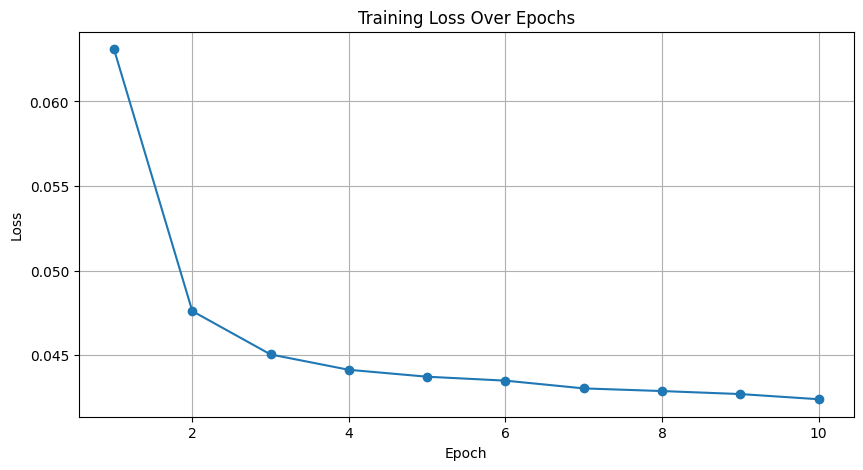

In [5]:
loss_values = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for sequences, targets in dataloader:
        sequences = sequences.view(-1, sequence_length, input_size)
        targets = targets.view(-1, output_size)  # Ensure target shape is (batch_size, output_size)
        outputs = model(sequences)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Calculate RMSE for current epoch
    rmse = math.sqrt(epoch_loss / len(dataloader))
    # Store the loss value for the current epoch
    loss_values.append(epoch_loss / len(dataloader))
    
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {rmse:.4f}')

print("Training complete.")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [6]:
torch.save(model.state_dict(), 'lstm_model.pth')

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot